In [1]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
from helpers import *

In [2]:
#file = PREPROCESSED_FOLDER + 'fulldataset_fullypreprocessed.json.bz2'
#data = pd.read_json(file, lines=True, compression='bz2')
#data
path = 'data.nosync/processed/quotes_labeled_cleaned_predicted.json.bz2'
print(path)
data = pd.read_json(path, lines=True, compression='bz2')

data.nosync/processed/quotes_labeled_cleaned_predicted.json.bz2


In [4]:
data

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID,quotation_clean,prob_dem
0,2015-08-31-000271,... a great day for veterans here in Littleton...,jeanne shaheen,2015-08-31 02:10:00,2,Q270316,D,S001181,great day veteran littleton across north count...,0.490675
1,2015-02-03-074650,The safety and security of our nation is at ri...,jeanne shaheen,2015-02-03 20:02:24,2,Q270316,D,S001181,safety security nation risk hold funding homel...,0.485331
2,2015-05-10-027625,It's been my experience that the faith communi...,jeanne shaheen,2015-05-10 22:48:46,1,Q270316,D,S001181,experience faith community willing partner gov...,0.622086
3,2015-09-01-113454,we need to bring the parents in so they can se...,jeanne shaheen,2015-09-01 02:12:00,2,Q270316,D,S001181,need bring parent see manufacturing worked sho...,0.613653
4,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",bernie sanders,2015-10-25 14:12:35,1,Q359442,D,S000033,ever gold standard trade agreement sander said...,0.935853
...,...,...,...,...,...,...,...,...,...,...
6396366,2020-02-10-100845,We're just worried about making sure we keep t...,sherrie sprenger,2020-02-10 00:00:00,1,Q7495360,R,None,worried making sure keep balance expression ri...,0.430030
6396367,2020-03-16-079753,We've all embraced strict proper hygiene proce...,robert abrams,2020-03-16 12:00:00,2,Q2156314,D,None,embraced strict proper hygiene procedure heard...,0.667447
6396368,2020-01-13-091997,What's important is that we keep moving forward.,laurie jinkins,2020-01-13 19:51:15,1,Q6501617,D,None,important keep moving forward,0.621014
6396369,2020-02-20-093793,"When they want a bill, they bring the bill to ...",j.t. wilcox,2020-02-20 22:12:45,1,Q6104393,R,None,want bill bring bill floor,0.342518


Lets anaylse some intervals of the probabilities score to see its most common words.
We could then for example relate words used to the strength of a politican inclination (how our model quantifies it).
The intervals used are:
- [0,0.25] and [0.25,0.5] for the republicans
- [0.5,0.75] and [0.75,1] for the democrats


In [3]:
rep = data[data.party_label == 'R']
dem = data[data.party_label == 'D']

This graph represent the distribution of the political score for each party (0-0.5 for the republicans, 0.5-1 for the democrats)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


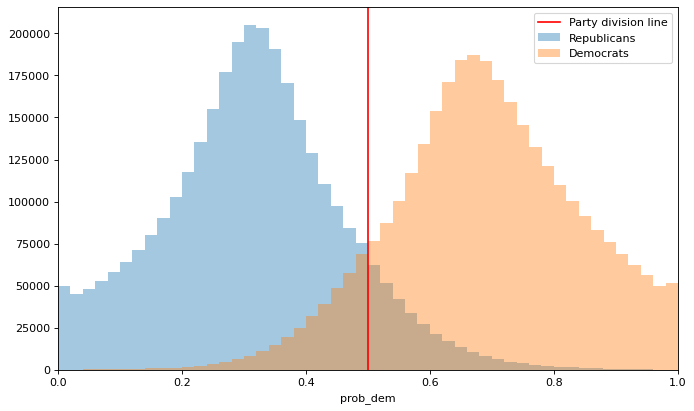

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=80)
sns.distplot(rep['prob_dem'],  kde=False, label='Republicans')
sns.distplot(dem['prob_dem'],  kde=False,label='Democrats')
plt.axvline(0.5, 0,1,color='r')
plt.xlim(0, 1)
plt.legend(labels=['Party division line','Republicans','Democrats'])

In [5]:
#divide in section (0, 0.25) and evaluate
rep_first_interval = rep[(rep['prob_dem'] >=0) & (rep['prob_dem'] <=0.25)]
rep_second_interval= rep[(rep['prob_dem'] >0.25) & (rep['prob_dem'] <=0.5)]

dem_first_interval = dem[(dem['prob_dem'] >=0.5) & (dem['prob_dem'] <=0.75)]
dem_second_interval = dem[(dem['prob_dem'] >0.75) & (dem['prob_dem'] <=1)]

In [6]:
from collections import Counter
import nltk
import texthero as hp
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def remove_verbs_from_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    #tags words, for example if the word is a verb in it's base form then it tags it with 'VB'
    #tagged becomes a list of tuples with (verb,tag) as format
    tagged = nltk.pos_tag(tokens)
    #filter all verbs from list
    tagged =list(filter(lambda x: x[1] not in  ['VB','VBD','VBG','VBN','VBP','VBZ','MD'],tagged))
    #remove tags from words
    words = list(map(lambda x: x[0], tagged))
    #print(words)
    #join the words to have a sentence once againg
    sentence = ' '.join(words)
    return sentence


def clean(series):
    series = hp.fillna(series)
    series = hp.lowercase(series)
    series = hp.remove_digits(series)
    series = hp.remove_punctuation(series)
    series = hp.remove_diacritics(series)
    series = hp.remove_stopwords(series)
    series = hp.remove_whitespace(series)
    
    return series
    

def get_interval_top_words(interval_df):
    #create list of words for all the quotes of an interval
    interval_word_list = interval_df['quotation'].apply(lambda x: x.split(' ')).tolist()
    interval_word_list = [item for sublist in interval_word_list for item in sublist]
    #clean the words so we only have important words
    interval_word_list  = clean(pd.Series(interval_word_list))
    
    # count the words
    words_to_count = (word for word in interval_word_list)
    c = Counter(words_to_count)
    return c
    

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giomonopoli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giomonopoli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
#rep
c_rep_first = get_interval_top_words(rep_first_interval)
c_rep_second = get_interval_top_words(rep_second_interval)

In [8]:
#dem
c_dem_first = get_interval_top_words(dem_first_interval)
c_dem_second = get_interval_top_words(dem_second_interval)

In [65]:
#create tuple with words and count

arr_all_intervals = [c_rep_first,c_rep_second,c_dem_first,c_dem_second]
all_info_intervals = []
for ls in arr_all_intervals:
    arr = []
    for i in ls.most_common(20):
        res = ''
        try:   
            res = remove_verbs_from_sentence(i[0])
            if res:
                arr.append((res,i[1]))
        except:
            None
    all_info_intervals.append(arr)
        
print(all_info_intervals)

[[('president', 113151), ('people', 103229), ('think', 98754), ('state', 63621), ('one', 58851), ('trump', 57108), ('like', 52354), ('us', 51164), ('want', 50470), ('time', 49217), ('states', 42046), ('government', 40438), ('american', 39926), ('need', 39635)], [('people', 171492), ('think', 137349), ('one', 92985), ('state', 87063), ('like', 84438), ('want', 83488), ('time', 80209), ('us', 79171), ('need', 77761), ('really', 62916), ('work', 62454), ('way', 60109), ('good', 58058)], [('people', 176036), ('think', 127215), ('one', 90747), ('us', 84180), ('want', 81131), ('like', 80476), ('need', 79653), ('state', 78443), ('time', 78172), ('really', 64547), ('work', 63106), ('way', 59549), ('president', 58475), ('right', 56298)], [('people', 161226), ('new', 88031), ('city', 73420), ('need', 65604), ('one', 64762), ('us', 64469), ('country', 61901), ('president', 60767), ('state', 59082), ('think', 56628), ('health', 53811), ('time', 52369), ('community', 52263), ('like', 52073), ('work

In [66]:
#doing the sum and dividing so we have proportion and not absolute values
for ls in all_info_intervals:
    sum=0
    for value in ls:
        sum+=value[1]
        
    for i in range(len(ls)):
        ls[i] = (ls[i][0],ls[i][1]/sum)
    

In [74]:
##function to create graphs (we wont put it, just take the plot given

drop_words = ['people','think','state','one','like','us','want','time','need','really','work','way']
"""
arr = [[],[],[],[]]
#drop useless words
for i in range(len(all_info_intervals)):
    
    for j in range(len(all_info_intervals[i])):
        
        tuple_da_togliere = all_info_intervals[i][j]
        
        if tuple_da_togliere[0] in drop_words:
            arr[i].append(tuple_da_togliere)
"""
for boh in all_info_intervals:
    for singlearray in boh:
        if singlearray[0] in drop_words:
            boh.remove(singlearray)

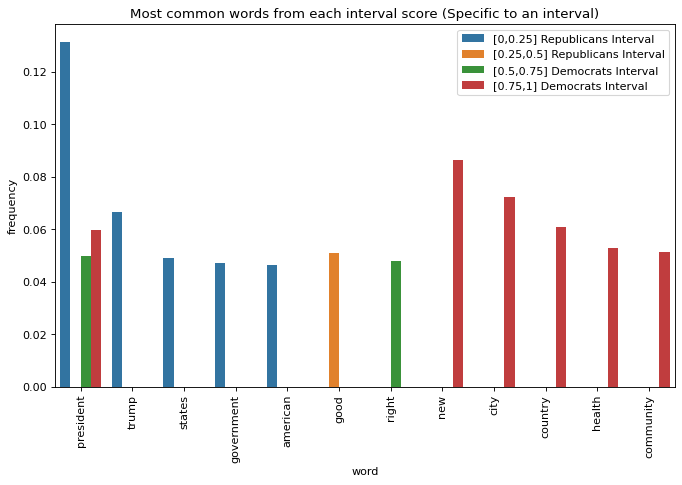

In [80]:
def make_df_word_freq(datas,interval_names):
    result = []
    for data,interval_name in zip(datas,interval_names):
        dataframe = pd.DataFrame(data , columns= ['word','frequency'])
        dataframe['interval'] = interval_name
        result.append(dataframe)
    return pd.concat(result)


#graph with overlapping words through intervals

data = make_df_word_freq(all_info_intervals,['[0,0.25] Republicans Interval','[0.25,0.5] Republicans Interval','[0.5,0.75] Democrats Interval','[0.75,1] Democrats Interval'])
plt.figure(figsize=(10, 6), dpi=80)
sns.barplot(data = data, x = 'word', y = 'frequency', hue='interval')
plt.xticks(rotation=90);
plt.title('Most common words from each interval score (Specific to an interval)')
plt.legend(loc='upper right');
plt.savefig('img_1(unique).png')

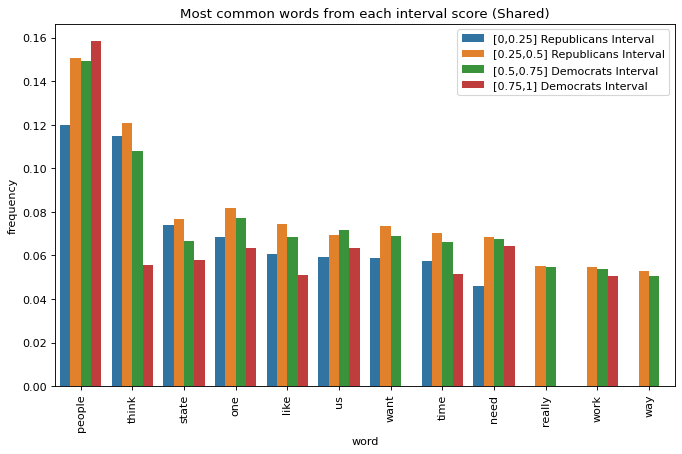

In [79]:
#the other graph with shared words

data = make_df_word_freq(arr,['[0,0.25] Republicans Interval','[0.25,0.5] Republicans Interval','[0.5,0.75] Democrats Interval','[0.75,1] Democrats Interval'])
plt.figure(figsize=(10, 6), dpi=80)
sns.barplot(data = data, x = 'word', y = 'frequency', hue='interval')
plt.xticks(rotation=90);
plt.title('Most common words from each interval score (Shared)')
plt.legend(loc='upper right')
plt.savefig('img_1(shared).png')